#### Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [3]:
data = pd.read_csv('../data_clean.csv')

In [15]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,2/25/15,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,12/9/14,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,2/18/15,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


#### Split numerical and categorical data

In [4]:
numeric = data.drop(['id', 'date'], axis=1).select_dtypes(include='number')

In [5]:
continous = numeric[['sqft_living','sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'price']]

#### Description of numerical data

In [6]:
continous.describe()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15,price
count,21419.000000,2.141900e+04,21419.000000,21419.000000,21419.000000,21419.000000,2.141900e+04
mean,2083.154256,1.512846e+04,1791.205285,291.948971,1988.414819,12776.095196,5.410700e+05
std,918.824411,4.153172e+04,828.696414,442.881467,685.538299,27346.204562,3.678205e+05
min,370.000000,5.200000e+02,370.000000,0.000000,399.000000,651.000000,7.800000e+04
25%,1430.000000,5.040000e+03,1200.000000,0.000000,1490.000000,5100.000000,3.230000e+05
50%,1920.000000,7.614000e+03,1560.000000,0.000000,1840.000000,7620.000000,4.500000e+05
75%,2550.000000,1.069200e+04,2220.000000,560.000000,2370.000000,10086.500000,6.450000e+05
max,13540.000000,1.651359e+06,9410.000000,4820.000000,6210.000000,871200.000000,7.700000e+06


#### Plot distributions of numerical variables

sqft_living


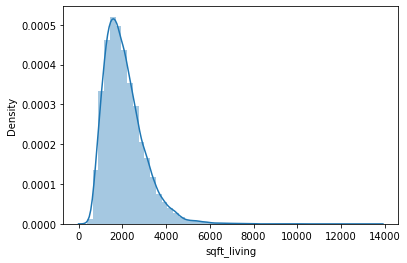

sqft_lot


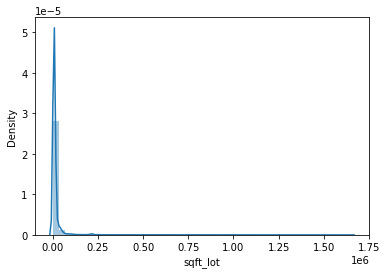

sqft_above


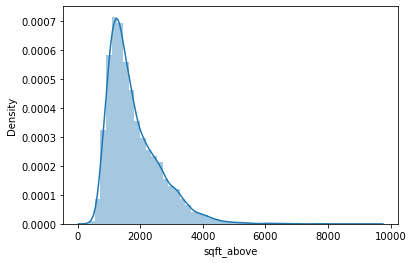

sqft_basement


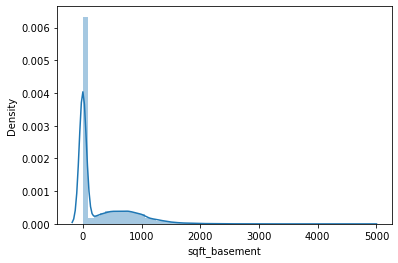

sqft_living15


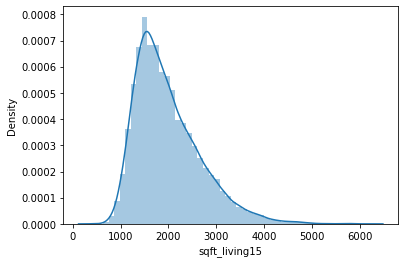

sqft_lot15


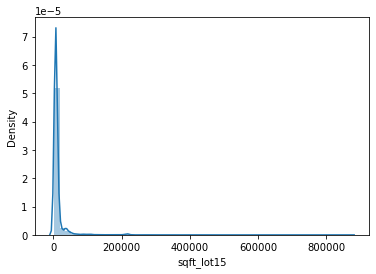

price


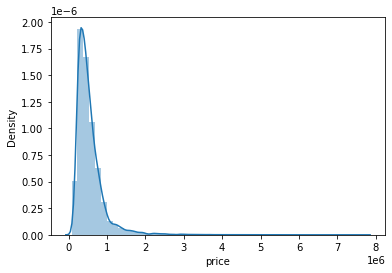

In [7]:
for x in continous:
    print(x)
    sns.distplot(continous[x])
    plt.show()

#### Outliers

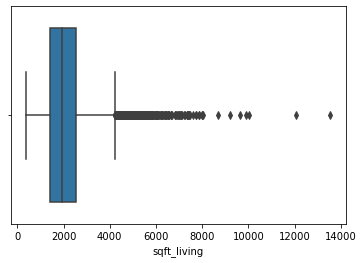

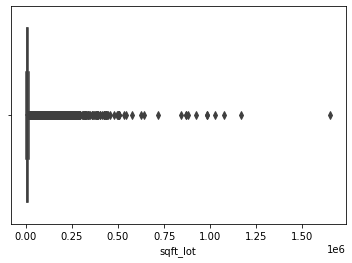

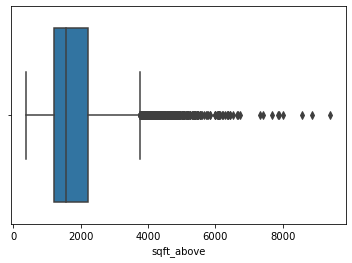

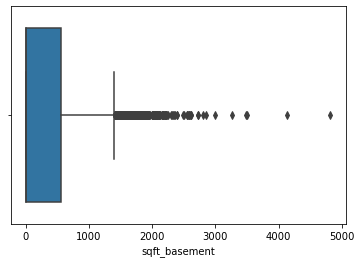

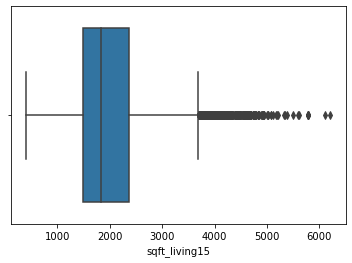

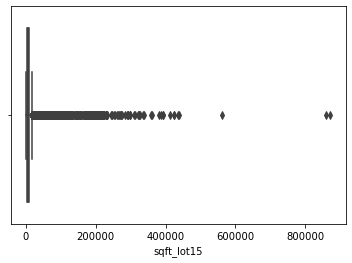

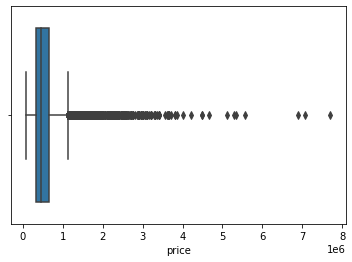

In [8]:
for col in list(continous.columns):
        sns.boxplot(continous[col])
        plt.show()

#### Plot correlation matrix

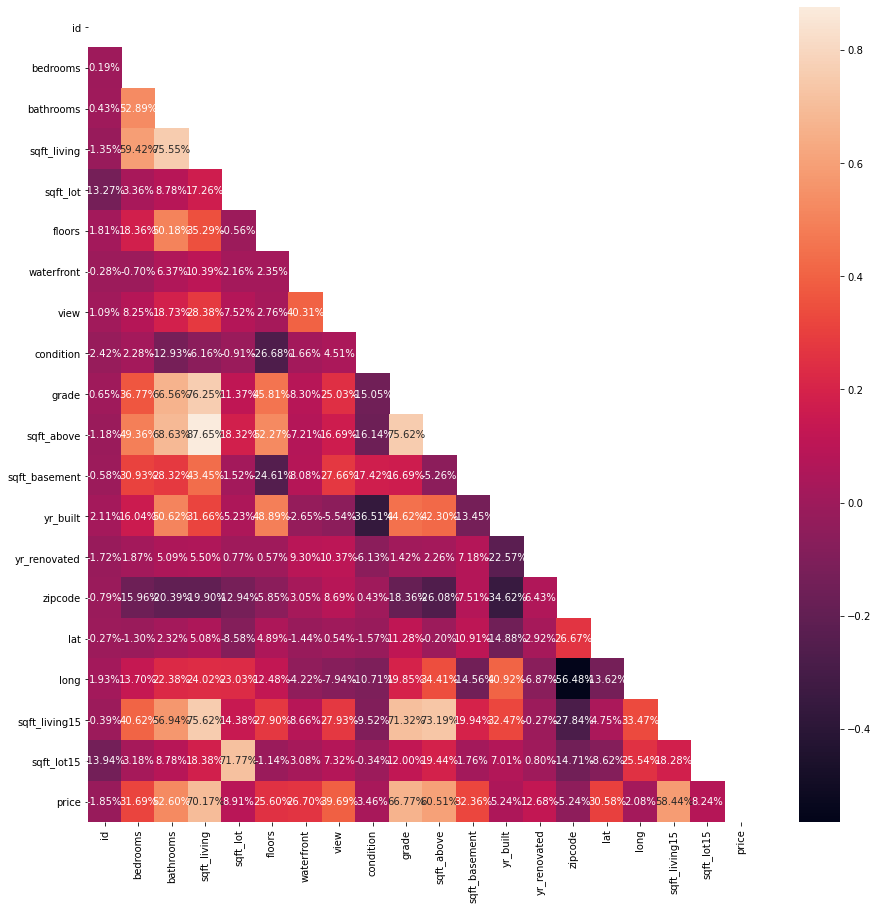

In [9]:
corr = data.corr('pearson')

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

pearson_meth =data.corr('pearson')
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.2%')
plt.show()

##### Variables correlated above 60% -- > sft_living, grade, sqft_above. <br> Variables correlated above 50% -- > bathrooms, sqft_living15. <br> Variables correlated above 30% -- > bedrooms, view, sqft_basement, lat. <br> Variables correlated above 20% -- > floors, waterfront. <br> Variables correlated bellow 20% -- > sqft_lot, condition, yr_built, yr_renovated, zipcode, long, sqft_lot15 

#### We'll perform a VIF test to check for multicollinearity and find which independent variables might be defined by other independent variables.

In [10]:
y, X = dmatrices('price ~ bedrooms+bathrooms+sqft_living+floors+waterfront+view+sqft_lot+condition+grade+sqft_above+yr_built+yr_renovated+zipcode+lat+long+sqft_lot15+sqft_living15',data=data, return_type='dataframe')

In [11]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
round(vif,3)

,VIF,variable
0,4593138.705,Intercept
1,1.714,bedrooms
2,3.378,bathrooms
3,8.736,sqft_living
4,2.011,floors
5,1.206,waterfront
6,1.437,view
7,2.098,sqft_lot
8,1.254,condition
9,3.425,grade


###### We still see moderate high multicollinearity in the sqft_living variable, we're going now to remove the variable 'bathrooms' as is kind of high correlated. We're not removing the sqft_living variable as it's the one with a higher correlation with the dependent variable.

In [12]:
y, X = dmatrices('price ~ bedrooms+sqft_living+floors+waterfront+view+sqft_lot+condition+grade++yr_built+yr_renovated+zipcode+lat+long+sqft_lot15+sqft_living15',data=data, return_type='dataframe')

In [13]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
round(vif,3)

,VIF,variable
0,4497564.829,Intercept
1,1.643,bedrooms
2,4.215,sqft_living
3,1.542,floors
4,1.204,waterfront
5,1.396,view
6,2.096,sqft_lot
7,1.237,condition
8,3.343,grade
9,2.161,yr_built


###### Now no VIF indicator is above 5, so no independent variables are defined by others.

###### Take into account that some of the variables like grade, will be considered later on as ordinal classificators and therefore dummified. The correlation with grade and Price is also strong as this is a measure created to classify the house and therefore it's selling price. 

In [14]:
numeric = numeric.drop(['bathrooms', 'sqft_above'],axis=1)